In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
from skimage import data
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import time

# Load data

In [3]:
# List of images to test
images = {
    "Astronaut": rgb2gray(data.astronaut()),
    "Camera": data.camera(),
    "Coins": data.coins(),
    "Moon": data.moon(),
    "brick": data.brick(),
    "Clock": data.clock(),
    "Coffee": rgb2gray(data.coffee()),
    "Page": data.page(),
    "Text": data.text(),
    "Rocket": rgb2gray(data.rocket())
}

# Normalize images to [0, 1]
images = {name: img / np.max(img).astype(float) for name, img in images.items()}

# Define compression method and evaluation metrics

In [2]:
# Function to compress image using Exact SVD
def compress_svd(image, k):
    U, S, Vt = np.linalg.svd(image, full_matrices=True)
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]
    compressed_image = np.dot(U_k, np.dot(S_k, Vt_k))
    return compressed_image

# Function to compress image using Randomized SVD
def compress_randomized_svd(image, k):
    U, S, Vt = randomized_svd(image, n_components=k, n_iter=7)
    S_k = np.diag(S)
    compressed_image = np.dot(U, np.dot(S_k, Vt))
    return compressed_image

# Function to calculate PSNR
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:  # Perfect match
        return float('inf')
    pixel_max = 1.0
    return 20 * np.log10(pixel_max / np.sqrt(mse))


# Specify parameters and run experiment

In [ ]:
k_values = [1, 3, 5, 8, 10, 13, 15]  # Number of singular values to retain
num_repeats = 5  # Number of repetitions for both SVD methods

# Process each image
all_result = []
for image_name, image in images.items():
    print(f"Processing image: {image_name}")
    results = {"k": [], "method": [], "mean_runtime": [], "std_runtime": [], "mean_ssim": [], "std_ssim": [], "mean_psnr": [], "std_psnr": []}

    for k in k_values:
        # Exact SVD (repeat 5 times)
        exact_runtimes, exact_ssim_values, exact_psnr_values = [], [], []
        for _ in range(num_repeats):
            start_time = time.time()
            svd_image = compress_svd(image, k)
            runtime = time.time() - start_time
            exact_runtimes.append(runtime)
            exact_ssim_values.append(ssim(image, svd_image, data_range=1.0))
            exact_psnr_values.append(psnr(image, svd_image))

        results["k"].append(k)
        results["method"].append("Exact SVD")
        results["mean_runtime"].append(np.mean(exact_runtimes))
        results["std_runtime"].append(np.std(exact_runtimes))
        results["mean_ssim"].append(np.mean(exact_ssim_values))
        results["std_ssim"].append(np.std(exact_ssim_values))
        results["mean_psnr"].append(np.mean(exact_psnr_values))
        results["std_psnr"].append(np.std(exact_psnr_values))

        # Randomized SVD (repeat 5 times)
        rsvd_runtimes, rsvd_ssim_values, rsvd_psnr_values = [], [], []
        for _ in range(num_repeats):
            start_time = time.time()
            rsvd_image = compress_randomized_svd(image, k)
            runtime = time.time() - start_time
            rsvd_runtimes.append(runtime)
            rsvd_ssim_values.append(ssim(image, rsvd_image, data_range=1.0))
            rsvd_psnr_values.append(psnr(image, rsvd_image))

        results["k"].append(k)
        results["method"].append("Randomized SVD")
        results["mean_runtime"].append(np.mean(rsvd_runtimes))
        results["std_runtime"].append(np.std(rsvd_runtimes))
        results["mean_ssim"].append(np.mean(rsvd_ssim_values))
        results["std_ssim"].append(np.std(rsvd_ssim_values))
        results["mean_psnr"].append(np.mean(rsvd_psnr_values))
        results["std_psnr"].append(np.std(rsvd_psnr_values))

    # Convert results to a DataFrame
    df = pd.DataFrame(results)
    df["image"] = image_name
    all_result.append(df)


# Save results

In [ ]:
save_path = "./"
all_result.to_csv(save_path + "res.csv")

# Some results

## 1. Image compression quality

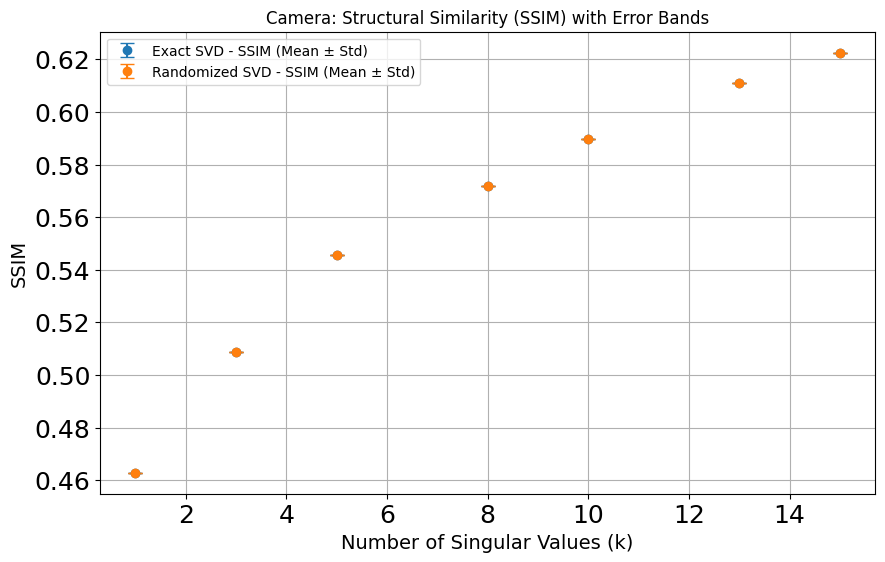

<Figure size 640x480 with 0 Axes>

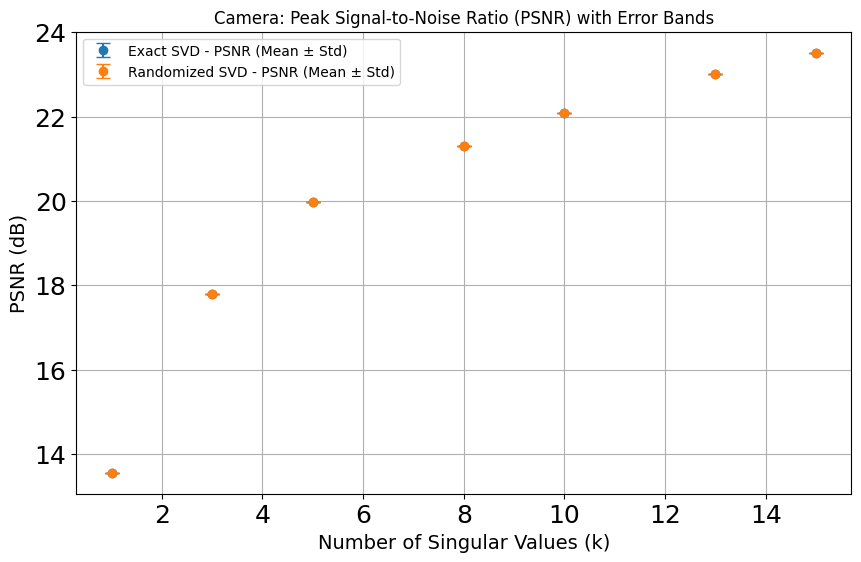

In [5]:
all = pd.read_csv("./res.csv")
image_name = "Camera"
df = all[all["image"]==image_name]

# Plot SSIM with error bands
plt.figure(figsize=(10, 6))
for method in df["method"].unique():
    subset = df[df["method"] == method]
    plt.errorbar(
        subset["k"],
        subset["mean_ssim"],
        yerr=subset["std_ssim"],
        label=f"{method} - SSIM (Mean ± Std)",
        fmt="o",
        capsize=5,
    )
plt.xlabel("Number of Singular Values (k)", fontsize=14)
plt.ylabel("SSIM", fontsize=14)
plt.xticks(fontsize=18)  # Change font size for x-axis ticks
plt.yticks(fontsize=18)  # Change font size for y-axis ticks
plt.title(f"{image_name}: Structural Similarity (SSIM) with Error Bands")
plt.legend()
plt.grid()
plt.show()
plt.savefig("as_ssim.pdf")



# Plot PSNR with error bands
plt.figure(figsize=(10, 6))
for method in df["method"].unique():
    subset = df[df["method"] == method]
    plt.errorbar(
        subset["k"],
        subset["mean_psnr"],
        yerr=subset["std_psnr"],
        label=f"{method} - PSNR (Mean ± Std)",
        fmt="o",
        capsize=5,
    )
plt.xlabel("Number of Singular Values (k)", fontsize=14)
plt.ylabel("PSNR (dB)", fontsize=14)
plt.xticks(fontsize=18)  # Change font size for x-axis ticks
plt.yticks(fontsize=18)  # Change font size for y-axis ticks
plt.title(f"{image_name}: Peak Signal-to-Noise Ratio (PSNR) with Error Bands")
plt.legend()
plt.grid()
plt.show()


## 2. running time ratio

In [8]:
speed = pd.DataFrame([all["k"], all["method"], all["mean_runtime"], all["image"]]).transpose()
speed_SVD = speed.loc[speed['method'] == 'Exact SVD']
speed_rSVD = speed.loc[speed['method'] == 'Randomized SVD']
speed_SVD["ratio"] = (speed_SVD["mean_runtime"].values / speed_rSVD["mean_runtime"].values).astype("float")
speed_res = pd.DataFrame([speed_SVD["k"], speed_SVD["method"], speed_SVD["ratio"], speed_SVD["image"]]).transpose()
pivoted_res = speed_res.pivot(index="k", columns="image", values="ratio")
pivoted_res

/tmp/ipykernel_1395172/1591308800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_SVD["ratio"] = (speed_SVD["mean_runtime"].values / speed_rSVD["mean_runtime"].values).astype("float")
/tmp/ipykernel_1395172/1591308800.py:6: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivoted_res = speed_res.pivot(index="k", columns="image", values="ratio")


image,Astronaut,Camera,Clock,Coffee,Coins,Moon,Page,Rocket,Text,brick
k,,,,,,,,,,
1,5.525823,6.782383,3.077838,3.464602,2.688576,3.90394,2.151673,4.274536,1.950974,3.421724
3,4.0216,4.997929,3.107646,2.711776,2.628888,2.651639,1.714807,3.821585,2.065956,5.74712
5,3.821965,4.561184,2.623125,3.121318,2.550043,2.43361,1.568431,4.195625,1.708334,4.628347
8,3.313087,3.801063,2.66125,2.8174,2.468943,2.705163,1.507355,3.234259,2.244492,4.562781
10,3.297575,4.265216,2.399053,2.741255,2.370865,2.952578,1.627207,3.138877,1.558395,2.747061
13,3.390036,3.915688,2.315308,2.748873,2.301464,1.160275,1.482141,3.314094,2.527151,3.15268
15,3.039481,3.343837,1.939128,2.16775,1.922692,1.354125,2.687936,2.345847,3.001461,2.806866


## 3. Accuracy

In [11]:
acc = pd.DataFrame([all["k"], all["method"], all["mean_ssim"], all["mean_psnr"], all["image"]]).transpose()
acc_SVD = acc.loc[acc['method'] == 'Exact SVD']
acc_rSVD = acc.loc[acc['method'] == 'Randomized SVD']

ssim_ratio = np.abs(((acc_SVD["mean_ssim"].values - acc_rSVD["mean_ssim"].values) / acc_SVD["mean_ssim"].values).astype("float"))
psnr_ratio = np.abs(((acc_SVD["mean_psnr"].values - acc_rSVD["mean_psnr"].values) / acc_SVD["mean_psnr"].values).astype("float"))

acc_SVD["ratio_ssim"] = -np.log10(ssim_ratio)
acc_SVD["ratio_psnr"] = -np.log10(psnr_ratio)

/tmp/ipykernel_1395172/4274116572.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_SVD["ratio_ssim"] = -np.log10(ssim_ratio)
/tmp/ipykernel_1395172/4274116572.py:9: RuntimeWarning: divide by zero encountered in log10
  acc_SVD["ratio_psnr"] = -np.log10(psnr_ratio)
/tmp/ipykernel_1395172/4274116572.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acc_SVD["ratio_psnr"] = -np.log10(psnr_ratio)


### a. psnr

In [ ]:
pivoted_res = acc_SVD.pivot(index="k", columns="image", values="ratio_psnr")
pivoted_res

/tmp/ipykernel_1395172/3106618806.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivoted_res = acc_SVD.pivot(index="k", columns="image", values="ratio_psnr")


image,Astronaut,Camera,Clock,Coffee,Coins,Moon,Page,Rocket,Text,brick
k,,,,,,,,,,
1,inf,15.581504,inf,inf,inf,inf,inf,15.505577,inf,inf
3,inf,inf,inf,inf,13.300240,inf,10.694552,inf,8.211234,11.163632
5,13.408233,15.272903,inf,15.742053,11.490389,inf,11.484744,13.811596,7.565491,9.519615
8,10.722670,10.645466,inf,12.240578,10.694757,10.748172,10.152005,9.934178,6.681337,7.989884
10,10.831451,10.257321,inf,11.151291,7.933518,9.337903,7.512360,9.329144,5.850731,8.089385
13,8.869267,8.696460,14.201760,9.651453,7.800064,9.117017,6.389774,7.403148,6.126516,7.964634
15,8.554293,7.804585,10.466612,7.554921,6.446972,8.201586,5.747945,6.662046,6.923711,7.777313


### b. ssim

In [13]:
pivoted_res = acc_SVD.pivot(index="k", columns="image", values="ratio_ssim")
pivoted_res

/tmp/ipykernel_1395172/1790292510.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivoted_res = acc_SVD.pivot(index="k", columns="image", values="ratio_ssim")


image,Astronaut,Camera,Clock,Coffee,Coins,Moon,Page,Rocket,Text,brick
k,,,,,,,,,,
1,13.379655,13.283565,13.279941,14.037410,13.987378,13.481244,13.797798,13.927043,13.101127,13.967875
3,10.575706,13.112205,13.220539,11.414183,8.577020,12.462194,6.388788,13.298674,5.093708,7.060516
5,8.565014,9.397649,13.266800,9.200922,7.880113,11.454021,6.927714,9.833791,4.929529,6.141599
8,6.770579,7.092087,13.514948,7.915944,7.202688,7.923797,6.736822,7.396392,4.833570,5.324773
10,7.770399,7.119982,12.703874,7.163332,6.105480,7.238556,5.006752,7.111618,4.911737,6.020388
13,6.495464,5.978501,11.241633,6.549724,6.345432,6.560033,5.339983,5.554496,5.423231,5.582017
15,5.766517,7.141884,9.924963,5.994606,5.479456,6.020030,6.032854,5.640565,5.790909,6.164673
